In [4]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_data, ZoningDataset

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_sql
from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor
from cities.utils.data_loader import db_connection

root = find_repo_root()

In [8]:
with db_connection() as conn:
        predictor = TractsModelPredictor(conn)

subset = predictor.data 



dict_keys(['parcel_sqm', 'mean_limit_original', 'downtown_overlap_original', 'median_value', 'housing_units', 'university_overlap', 'housing_units_original', 'population_density', 'total_population', 'total_value', 'downtown_overlap', 'university_overlap_original', 'median_distance', 'segregation_original', 'income', 'total_value_original', 'white_original'])


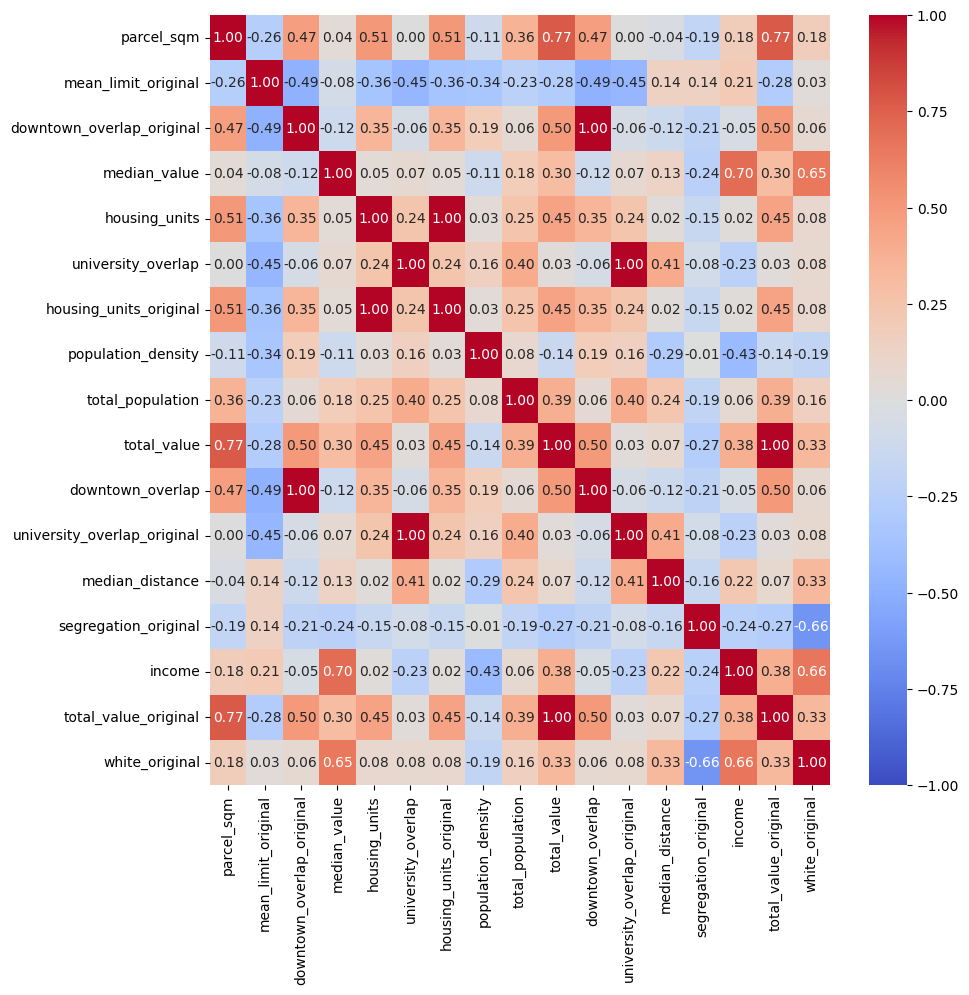

In [10]:
# plot correlations between dictionary of tensors subset['continuous'] variables
continuous_numpy_dict = {key: value.detach().cpu().numpy() for key, value in subset['continuous'].items()}


# plot correlations between dictionary of tensors subset['continuous'] variables
# make sure zero is white

continuous_df = pd.DataFrame(continuous_numpy_dict)
correlation_matrix = continuous_df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  # or 'seismic'
    center=0,         # Ensures zero is in the center of the colormap
    vmin=-1,          # Minimum value for the colormap
    vmax=1            # Maximum value for the colormap
)
plt.show()


# note total_population  is not correlated with population density


tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0, 0, 0,  ..., 1, 1, 1])


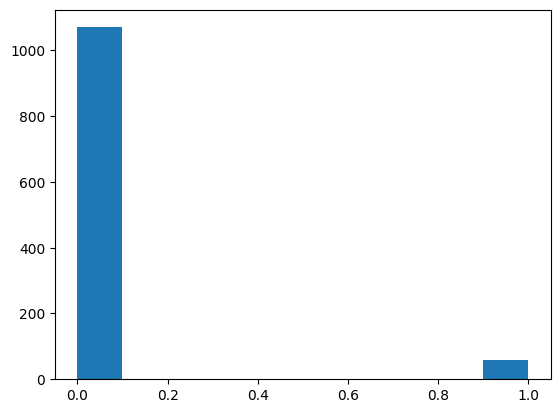

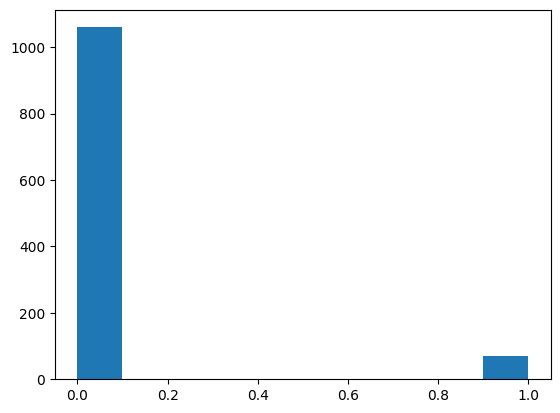

In [11]:
subset['categorical']['university_index'] = (subset['continuous']['university_overlap'] >= 3).to(torch.int64)
subset['categorical']['downtown_index'] = (subset["continuous"]['downtown_overlap'] >= 3).to(torch.int64)

print(subset['categorical']['university_index'])
print(subset['categorical']['downtown_index'])

plt.hist(subset['categorical']['university_index'])
plt.show()

plt.hist(subset['categorical']['downtown_index'])
plt.show()
        

In [12]:
columns_to_standardize = [
    "housing_units_original",
    "total_value_original",
    "university_overlap_original",
    "downtown_overlap_original",
]

new_standardization_dict = {}

for column in columns_to_standardize:
    new_standardization_dict[column] = {
        "mean": subset['continuous'][column].mean(),
        "std": subset['continuous'][column].std(),
    }


In [13]:

pg_census_tracts_dataset = ZoningDataset(
    subset['categorical'], subset['continuous'], standardization_dictionary=new_standardization_dict
)


assert "parcel_sqm" in subset['continuous'].keys()

pg_census_tracts_loader = DataLoader(pg_census_tracts_dataset, batch_size=len(pg_census_tracts_dataset), shuffle=True)

pg_census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

torch.save(pg_census_tracts_dataset, pg_census_tracts_data_path)